In [1]:
!wget https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv

--2019-02-27 01:01:13--  https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3093160 (2.9M) [text/plain]
Saving to: ‘colloquial-indonesian-lexicon.csv’

colloquial-indonesi 100%[===================>]   2.95M  --.-KB/s    in 0.05s   

2019-02-27 01:01:13 (57.1 MB/s) - ‘colloquial-indonesian-lexicon.csv’ saved [3093160/3093160]



In [2]:
!git clone https://gist.github.com/f7b7c7758a46da49f84bc68b47997d69.git
!bash f7b7c7758a46da49f84bc68b47997d69/pytorch041_cuda92_colab.sh

Cloning into 'f7b7c7758a46da49f84bc68b47997d69'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
--2019-02-27 01:01:18--  https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64.deb?W9hC0lxtteiCMPg3RYuA6M7lnOUfooH0VXR2DtSVu-XhRN1YSqThEYXf0cV7yh-e3NzDmezKOUr4IkHbWO918QqrfwAqrJpti_jPbiBuViBhdCTVZ9xkWCZ9zMMo1sokEoa_2wV_Am9TRStbmChdooI1-OW2xFMVcFD3JDUTuojKfvRAeOBNHd_BpmSfEoHEpa6Hf41NvWxV-93Ey62yig [following]
--2019-02-27 01:01:18--  https://developer.download.nvidia.com/compute/cuda/9.

In [3]:
!pip install tqdm

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import torch
from torch import nn, optim

In [2]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(device)

cpu


In [3]:
df = pd.read_csv('colloquial-indonesian-lexicon.csv')

In [4]:
X = df['slang']
y = df['formal']
SOS_TOKEN = 0
EOS_TOKEN = 1
PAD_TOKEN = ord('*')

In [7]:
def apply_padding(_str, n_max_char, zero_char='*'):
    len_str = len(_str)
    if len_str >= n_max_char:
        return _str[:n_max_char]
  
    else:
        return _str + ''.join([zero_char for t in range(n_max_char - len_str)])
    
def replace_punctuations(x, replace_with='*'):
    return [str(e) if str(e).isalpha() else replace_with for e in x]

def lord(x):
  """make string into integer"""
  return [SOS_TOKEN] + [ord(x1) for x1 in x] + [EOS_TOKEN]

def tchr(x):
    return ''.join([chr(y) for y in x[1:-2] if y != PAD_TOKEN])

In [8]:
max_len_slang = X.apply(len).max()
max_len_formal = y.apply(len).max()
print('max_len_slang: {}, max_len_formal {}'.format(max_len_slang, max_len_formal))

max_len_slang: 59, max_len_formal 22


In [9]:
def encoded_from_sentence(text):
  return lord(replace_punctuations(apply_padding(text, max_len_slang)))

def decoded_to_sentence(encoded):
  return tchr(encoded)

In [10]:
X = X.apply(apply_padding, args=(max_len_slang,)).apply(list).apply(np.array).apply(replace_punctuations).apply(lord)
y = y.apply(apply_padding, args=(max_len_slang,)).apply(list).apply(np.array).apply(replace_punctuations).apply(lord)

In [11]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3)

In [12]:
def to_torch(x, device=device):
    return torch.from_numpy(np.array(x.values.tolist())).to(device)

In [13]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        # make into 1x1 dimension
        embedded = self.embedding(input).view(1, 1, -1)
        
        # gru or other RNN will output: output, hidden layer
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    def init_hidden(self, device=device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def init_hidden(self, device=device):
        return torch.zeros(1,1, self.hidden_size, device=device)
        

In [15]:
input_size = max_len_slang + 1
vocab_size = 122 + 2 #include eos and sos
embed_dim = max_len_slang + 1
hidden_size = 128
output_size = max_len_slang + 1
e = Encoder(vocab_size, hidden_size).to(device)
d = Decoder(hidden_size, vocab_size).to(device)
criterion = nn.NLLLoss(ignore_index=PAD_TOKEN)
eoptimizer = optim.Adam(e.parameters())
doptimizer = optim.Adam(d.parameters())


In [16]:
def train(input_tensor, target_tensor, e, d, eop, dop, criterion, max_length=61):
    eh = e.init_hidden()
    eop.zero_grad()
    dop.zero_grad()
    
    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)
    
    eoutputs = torch.zeros(max_length, e.hidden_size)
    loss = 0
    
    for ei in range(input_length):
#         print(ei)
        eo, eh = e(input_tensor[ei], eh)
        eoutputs[ei] = eo[0,0]
    
    # use only last context from encoder
    dh = eh
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
    for di in range(1, output_length):
        do, dh = d(decoder_input, dh)
        topv, topi = do.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(do, target_tensor[di].view(1))
        if decoder_input.item() == EOS_TOKEN:
            break
    loss.backward()
    eop.step()
    dop.step()
    
    return loss.item() / max_length
        
    

In [17]:
epochs = 20
losses = []
epoch_avg_losses = []

print_every = 1000
for ep in range(epochs):
    epoch_losses = []
    epoch_loss = 0
    for input_tensor, output_tensor in tqdm(zip(to_torch(X_train), to_torch(y_train))): 
        avg_loss = train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
        losses.append(avg_loss)
        epoch_losses.append(avg_loss)
        
    
    epoch_loss = np.average(epoch_losses)
    epoch_avg_losses.append(epoch_loss)        
    

318it [00:21, 15.69it/s]

KeyboardInterrupt: 

318it [00:40,  7.94it/s]

In [ ]:
import matplotlib.pyplot as plt

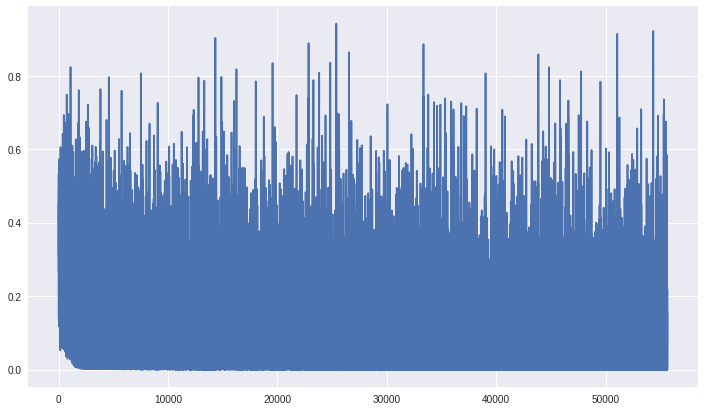

In [22]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(losses))), losses)
plt.show()


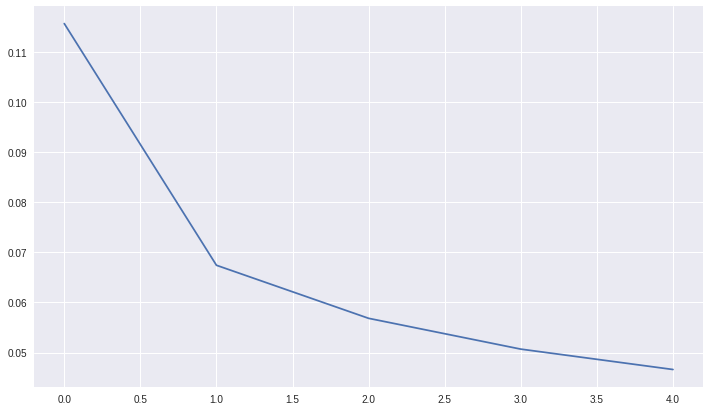

In [23]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(epoch_avg_losses))), epoch_avg_losses)
plt.show()

In [ ]:
def evaluate(e, d, sentence, max_length=61, device=device):
  with torch.no_grad():
    input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence)]))[0]
    input_length = input_tensor.size()[0]
    eh = e.init_hidden()
    
    eoutputs = torch.zeros(max_length, e.hidden_size, device=device)
    
    for ei in range(input_length):
      eo, eh = e(input_tensor[ei],  eh)
      eoutputs[ei] = eo[0,0]
      
    dinput = torch.tensor([[SOS_TOKEN]], device=device)
    
    doutputs = []
    dh = eh
    for di in range(max_length):
      do, dh = d(dinput, dh)
      topv, topi = do.topk(1)
      
      doutputs.append(topi.item())
      if topi.item() == EOS_TOKEN:
        break;
        
    return decoded_to_sentence(doutputs)

In [64]:
evaluate(e, d, 'baguuuuus')

'amgsgggggggggggggggggggggggggggggggggggggggggggggggggggggg'

In [62]:
df[
    df.category1 == 'elongasi'
].head(20)

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
5,eeeehhhh,eh,1,Eh ada @ghessawarsana . Eeeehhhh,elongasi,0,0
7,hallo,halo,1,Hallo kakak tulus,elongasi,0,0
10,daah,dah,1,Senyumnya bikin aku meleleh daah?? @tulusm,elongasi,0,0
11,aaaaahhhh,ah,1,"Aaaaahhhh @tulusm ,aku suka banget sama pria i...",elongasi,0,0
12,yaa,ya,1,"Aaaaahhhh @tulusm ,aku suka banget sama pria i...",elongasi,0,0
15,amiin,amin,1,Udo @tulusm happy milad ya..?? smga diberi kes...,elongasi,0,0
23,akuuu,aku,1,Mas tulus kenapa sii.. Orangnya nyenengin bgt....,elongasi,0,0
25,yaa,ya,1,Mas tulus kenapa sii.. Orangnya nyenengin bgt....,elongasi,0,0
